# Оптимизация маршрута

Представим, что есть курьер, который оказался в рандомном месте в городе и которому нужно доставить 5 заказов. А времени мало, поэтому нужно доставить заказы, как можно быстрее. Сперва он хочет доставлять заказы в том порядке, в котором они пришли в приложение. Но можно ли построить маршрут оптимальнее? И насколько оптимальнее он будет? Попробую решить задачу.

Задача — программа, которая выполняет следующее:
* Генерирует карту города размером 1000 на 1000 ячеек, содердащую дома, землю и воду
* Определяет точку старта маршрута (курьер);
* Генерирует 5 точек (доставки), через которые должен пройти маршрут;
* Прокладывает прямой маршрут, в порядке очередности точек;
* Прокладывает оптимизированный маршрут, самый короткий

### Часть 1: импортирую необходимые для работы библиотеки

In [1]:
import random
import numpy as np
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap

### Часть 2: класс для генерации карты города

Необходимо сгенерировать город на карте со следующими характеристиками:
* размер: 1000 на 1000 точек
* три типа поверхности: земля (проходима), вода (непроходима), здания (непроходимы)
* вода двух типов: озера и реки, реки пересекают мосты (для проходимости)
* здания трех типов: крупные, средние, мелкие, расположены паттерном кварталов

In [2]:
# Задам класс для генерации карты города
class CityMapGenerator:
    """
    Генерирует карту города с реками, озерами, мостами и зданиями
    """
    def __init__(self, config):
        self.config = config
        self.H, self.W = config['map']['height'], config['map']['width']
        self.M = np.ones((self.H, self.W), dtype=int)

    def _generate_river(self, start_x, start_y, width_range, target_edge='bottom'):
        """Генерирует реки"""
        x, y = start_x, start_y
        width = random.randint(*width_range)
        dy = 1 if target_edge == 'bottom' else -1
        target_y = self.H - 1 if target_edge == 'bottom' else 0
        river_map = np.zeros((self.H, self.W), dtype=float)

        # Сглажу края у реки
        while y != target_y:
            for dx in range(-width // 2, width // 2 + 1):
                if 0 <= x + dx < self.W:
                    distance_from_center = abs(dx) / (width / 2)
                    intensity = max(0, 1 - distance_from_center**2)
                    river_map[y, x + dx] = max(river_map[y, x + dx], intensity)
            
            y += dy
            x = np.clip(x + random.randint(-2, 2), width, self.W - width - 1)
            if random.random() < 0.03:
                width = random.randint(*width_range)
        
        # Применю гауссово размытие для сглаживания
        river_map = gaussian_filter(river_map, sigma=2.0)
        self.M[river_map > 0.3] = 0

    def _generate_lake(self, center_x, center_y, radius_x, radius_y):
        """Генерирует озеро"""
        lake_map = np.zeros((self.H, self.W), dtype=float)
        
        y_min, y_max = max(0, center_y - radius_y - 10), min(self.H, center_y + radius_y + 10)
        x_min, x_max = max(0, center_x - radius_x - 10), min(self.W, center_x + radius_x + 10)
        
        for y in range(y_min, y_max):
            for x in range(x_min, x_max):
                # Расстояние от центра (нормализованное)
                dist = ((x - center_x) / radius_x)**2 + ((y - center_y) / radius_y)**2
                if dist <= 1.2:
                    lake_map[y, x] = max(0, 1 - dist + random.uniform(-0.1, 0.1))
        
        # Размытие
        lake_map = gaussian_filter(lake_map, sigma=3.0)
        self.M[lake_map > 0.4] = 0

    def add_bridges(self):
        """Добавляет мосты через реки"""
        print("Добавление мостов...")
        cfg = self.config['bridges']
        
        # Поиск подходящих мест (узкие участки рек)
        possible_y = [y for y in range(150, self.H - 150, 20)
                      if 1 < len(np.where(np.diff(self.M[y, :]) != 0)[0]) < 10]
        
        if not possible_y:
            print("Не удалось найти подходящих мест для мостов.")
            return

        # Строю мосты
        for y_center in random.sample(possible_y, min(cfg['num_bridges'], len(possible_y))):
            water_idx = np.where(self.M[y_center, :] == 0)[0]
            if water_idx.size > 0:
                x_start, x_end = water_idx[0], water_idx[-1]
                y_range = slice(max(0, y_center - cfg['bridge_width'] // 2),
                               min(self.H, y_center + cfg['bridge_width'] // 2))
                self.M[y_range, x_start:x_end + 1] = 1
        
        print(f"Построено мостов: {min(cfg['num_bridges'] * 2, len(possible_y))}")

    def generate_buildings(self):
        """Строит здания на карте"""
        print("Добавление зданий...")
        for b_type, params in self.config['buildings'].items():
            placed = 0
            for _ in range(params['attempts']):
                if placed >= params['count']:
                    break
                w, h = random.randint(*params['width_range']), random.randint(*params['height_range'])
                x, y = random.randint(0, self.W - w - 1), random.randint(0, self.H - h - 1)
                
                # Проверка, можно ли разместить здание на пустых местах
                if not np.any(self.M[y:y+h, x:x+w] != 1):
                    self.M[y:y+h, x:x+w] = 2
                    placed += 1
            print(f"Построено {b_type} зданий: {placed}")

    def get_map(self):
        """Генерирует полную карту"""
        for params in self.config['rivers']:
            self._generate_river(**params)
        print("\n" + "=" * 70)
        print("ГЕНЕРАЦИЯ КАРТЫ")
        print("=" * 70)
        print("Добавление рек...")
        
        self.add_bridges()
        
        for params in self.config['lakes']:
            self._generate_lake(**params)
        print("Добавление озер...")
        
        self.generate_buildings()
        return self.M

### Часть 3: класс для визуализации карты

Тут решаю такие задачи:
* отрисовка карты
* разные объекты покрасить в разные цвета
* отобразить легенду объектов

In [3]:
# Класс визуализации
class MapVisualizer:
    """
    Визуализирует карту города с использованием Matplotlib и Seaborn
    """
    def __init__(self, map_data, colors):
        self.M = map_data
        self.colors = colors
        sns.set_style("white")

    def plot(self, scale=10, dpi=150, title='Карта города — общий обзор', 
             route=None, start=None, deliveries=None):
        """
        Универсальная отрисовка карты
        """
        M_preview = self.M[::scale, ::scale]
        
        fig, ax = plt.subplots(figsize=(12, 12), dpi=dpi)
        
        # Задаю цветовую палитру
        cmap = ListedColormap([self.colors['water'], self.colors['land'], self.colors['building']])

        ax.imshow(M_preview, cmap=cmap, origin='upper')

        # Отрисовываю маршрут, если он передан
        if route:
            ax.plot([p[0]/scale for p in route], [p[1]/scale for p in route], 
                    color='#FF6B35', linewidth=4, alpha=0.85, label=f'Маршрут ({len(route)} шагов)', zorder=5)

        # Отрисовываю стартовую точку (курьера)
        if start:
            ax.scatter(start[0]/scale, start[1]/scale, marker='s', s=300, color='#2ca02c', 
                       edgecolors='white', linewidths=2.5, label='Старт', zorder=10)

        # Отрисовываю точки доставки с порядковыми номерами
        if deliveries:
            for i, point in enumerate(deliveries, 1):
                # Маркер точки доставки
                ax.scatter(point[0]/scale, point[1]/scale, marker='*', s=400, color='#d62728', 
                           edgecolors='white', linewidths=2, zorder=10)
                # Номер на белом фоне
                ax.text(point[0]/scale, point[1]/scale, str(i), 
                        fontsize=14, fontweight='bold', color='black',
                        ha='center', va='center', zorder=11,
                        bbox=dict(boxstyle='circle,pad=0.3', facecolor='white', edgecolor='black', linewidth=1.5))

        ax.set_title(title, fontsize=18, weight='bold')
        ax.set_xlabel(f'X (масштаб 1:{scale})', fontsize=12)
        ax.set_ylabel(f'Y (масштаб 1:{scale})', fontsize=12)
        ax.grid(False)

        # Легенда
        legend_elements = [
            Patch(facecolor=self.colors['land'], label='Земля'),
            Patch(facecolor=self.colors['water'], label='Вода'),
            Patch(facecolor=self.colors['building'], label='Здания')
        ]
        
        # Добавляю элементы маршрута, если они есть
        if route:
            from matplotlib.lines import Line2D
            legend_elements.append(Line2D([0], [0], color='#FF6B35', linewidth=4, 
                                         label=f'Маршрут ({len(route)} шагов)'))
        if start:
            from matplotlib.lines import Line2D
            legend_elements.append(Line2D([0], [0], marker='s', color='w', 
                                         markerfacecolor='#2ca02c', markersize=12, 
                                         markeredgecolor='white', markeredgewidth=2,
                                         label='Старт', linestyle='None'))
        if deliveries:
            from matplotlib.lines import Line2D
            legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor='white', markersize=15, 
                                         markeredgecolor='black', markeredgewidth=2,
                                         label='Точки доставки', linestyle='None'))

        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1), 
                 fontsize=12, frameon=True, shadow=True)

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.show()
        plt.close()

### Часть 4: класс для навигатора (поиск маршрутов доставки)

Нужно построить два маршрута со следующими характеристиками:

#### Прямой маршрут
Курьер направляется в порядке очередности выдачи заказов: сперва 1-й заказ, потом 2-й заказ и т.д.
Между двумя очередными точками маршрут находится по методу BFS (Breadth-First Search) — поиск в ширину: использует классический алгоритм поиска для нахождения кратчайшего пути между двумя точками на сетке.

#### Оптимизированный маршрут
На каждом шаге (маршруте до следующей точки) алгоритм делает локально оптимальный выбор (идет в ближайшую точку), не заботясь о глобальной оптимальности всего маршрута. Однако для практических задач с 5-20 точками доставки жадный алгоритм дает приемлемое решение за разумное время.

Подробнее о том как работают методы.

### BFS
1. Инициализация: cтартовая точка помещается в очередь, создается словарь родителей для отслеживания пути
2. Итеративный процесс: алгоритм извлекает вершины из очереди по принципу "первым пришел — первым вышел" и исследует все непосещенные соседние клетки (вверх, вниз, влево, вправо)
3. Проверка проходимости: для каждой клетки проверяется условие проходимости (только земля)
4. Завершение: как только достигается целевая точка, алгоритм восстанавливает путь, двигаясь по цепочке родителей от конца к началу

После того как BFS достиг целевой точки, путь восстанавливается в обратном порядке через словарь:
Цель ← Предок цели ← Предок предка ← ... ← Старт
Далее найденные таким образом пути от точки к точки "склеиваются" в один:
Старт → Точка 1 → Точка 2 → ... → Точка 5

### Жадный алгоритм
1. Начинаем со стартовой точки
2. Из текущей позиции находится ближайшая непосещенная точку доставки (перебираем все точки и вычисляется кратчайшие пути с помощью BFS)
3. Перемещение в эту точку, добавляется сегмент к маршруту
4. Повторение, пока не соединим все точки



In [4]:
# Класс построения маршрутов
class Navigator:
    """
    Строит кратчайшие маршруты по карте
    """
    def __init__(self, city_map):
        self.city = np.array(city_map, dtype=int)
        self.H, self.W = self.city.shape
        self.dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        self.walkable = self.city == 1
        
        print(f"Карта: {self.H}×{self.W}")
        print(f"Проходимых клеток: {self.walkable.sum()} ({self.walkable.sum()/(self.H*self.W)*100:.1f}%)")

    def _valid(self, p):
        x, y = p
        return 0 <= x < self.W and 0 <= y < self.H and self.walkable[y, x]

    def shortest_path(self, start, end):
        if start == end:
            return []
        if not (self._valid(start) and self._valid(end)):
            return None

        q = deque([start])
        parent = {start: None}

        while q:
            v = q.popleft()
            if v == end:
                path = []
                cur = end
                while cur != start:
                    path.append(cur)
                    cur = parent[cur]
                path.reverse()
                return path

            vx, vy = v
            for dx, dy in self.dirs:
                nx, ny = vx + dx, vy + dy
                u = (nx, ny)
                if self._valid(u) and u not in parent:
                    parent[u] = v
                    q.append(u)

        return None

    def route_in_order(self, start, points):
        """Маршрут точек по порядку"""
        route = []
        current = start
        for point in points:
            segment = self.shortest_path(current, point)
            if segment is None:
                return None
            route.extend(segment)
            current = point
        return route

    def route_greedy(self, start, points):
        """Жадный алгоритм (ближайший сосед)"""
        route = []
        current = start
        remaining = list(points)

        while remaining:
            best_point = None
            best_segment = None
            best_distance = float('inf')

            for point in remaining:
                segment = self.shortest_path(current, point)
                if segment is not None and len(segment) < best_distance:
                    best_point = point
                    best_segment = segment
                    best_distance = len(segment)

            if best_point is None:
                return None

            route.extend(best_segment)
            current = best_point
            remaining.remove(best_point)

        return route

In [5]:
# Вспомогательная функция
def find_valid_point(M, min_dist_from_edge=50, max_attempts=1000):
    """Находит случайную проходимую точку на карте"""
    H, W = M.shape
    for _ in range(max_attempts):
        x = random.randint(min_dist_from_edge, W - min_dist_from_edge - 1)
        y = random.randint(min_dist_from_edge, H - min_dist_from_edge - 1)
        if M[y, x] == 1:
            return (x, y)
    return None


ГЕНЕРАЦИЯ КАРТЫ
Добавление рек...
Добавление мостов...
Построено мостов: 2
Добавление озер...
Добавление зданий...
Построено крупных зданий: 20
Построено средних зданий: 84
Построено малых зданий: 300


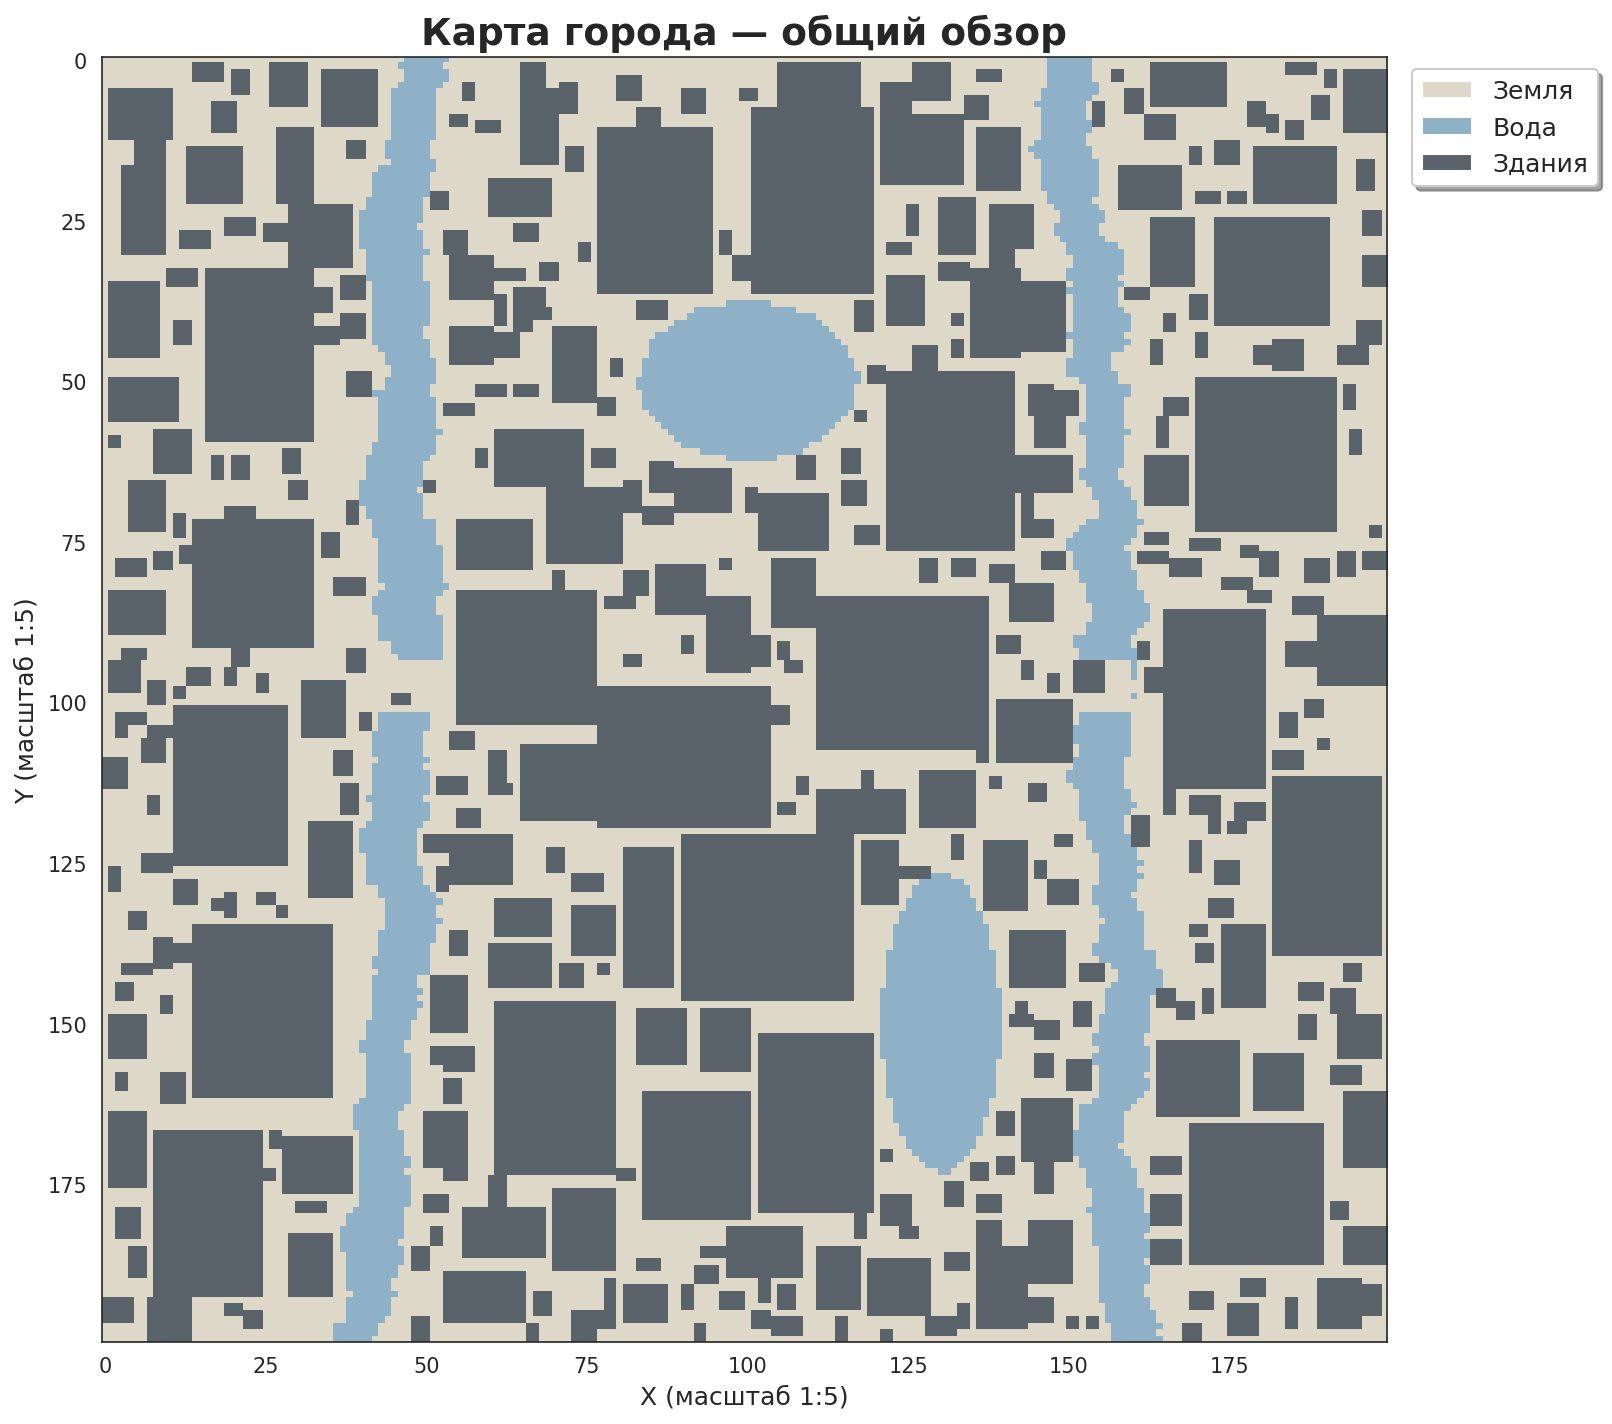


СТАТИСТИКА СГЕНЕРИРОВАННОЙ КАРТЫ
Размер: 1000×1000
Земля: 393251 клеток (39.3%)
Вода: 110585 клеток (11.1%)
Здания: 496164 клеток (49.6%)
Карта: 1000×1000
Проходимых клеток: 393251 (39.3%)

ГЕНЕРАЦИЯ ТОЧЕК ДОСТАВКИ
Местоположение курьера: (266, 202)
Точка доставки 1: (444, 787)
Точка доставки 2: (764, 302)
Точка доставки 3: (724, 562)
Точка доставки 4: (365, 410)
Точка доставки 5: (724, 885)

ПОСТРОЕНИЕ МАРШРУТОВ
Прямой маршрут: 3289 шагов
Оптимизированный маршрут: 1969 шагов


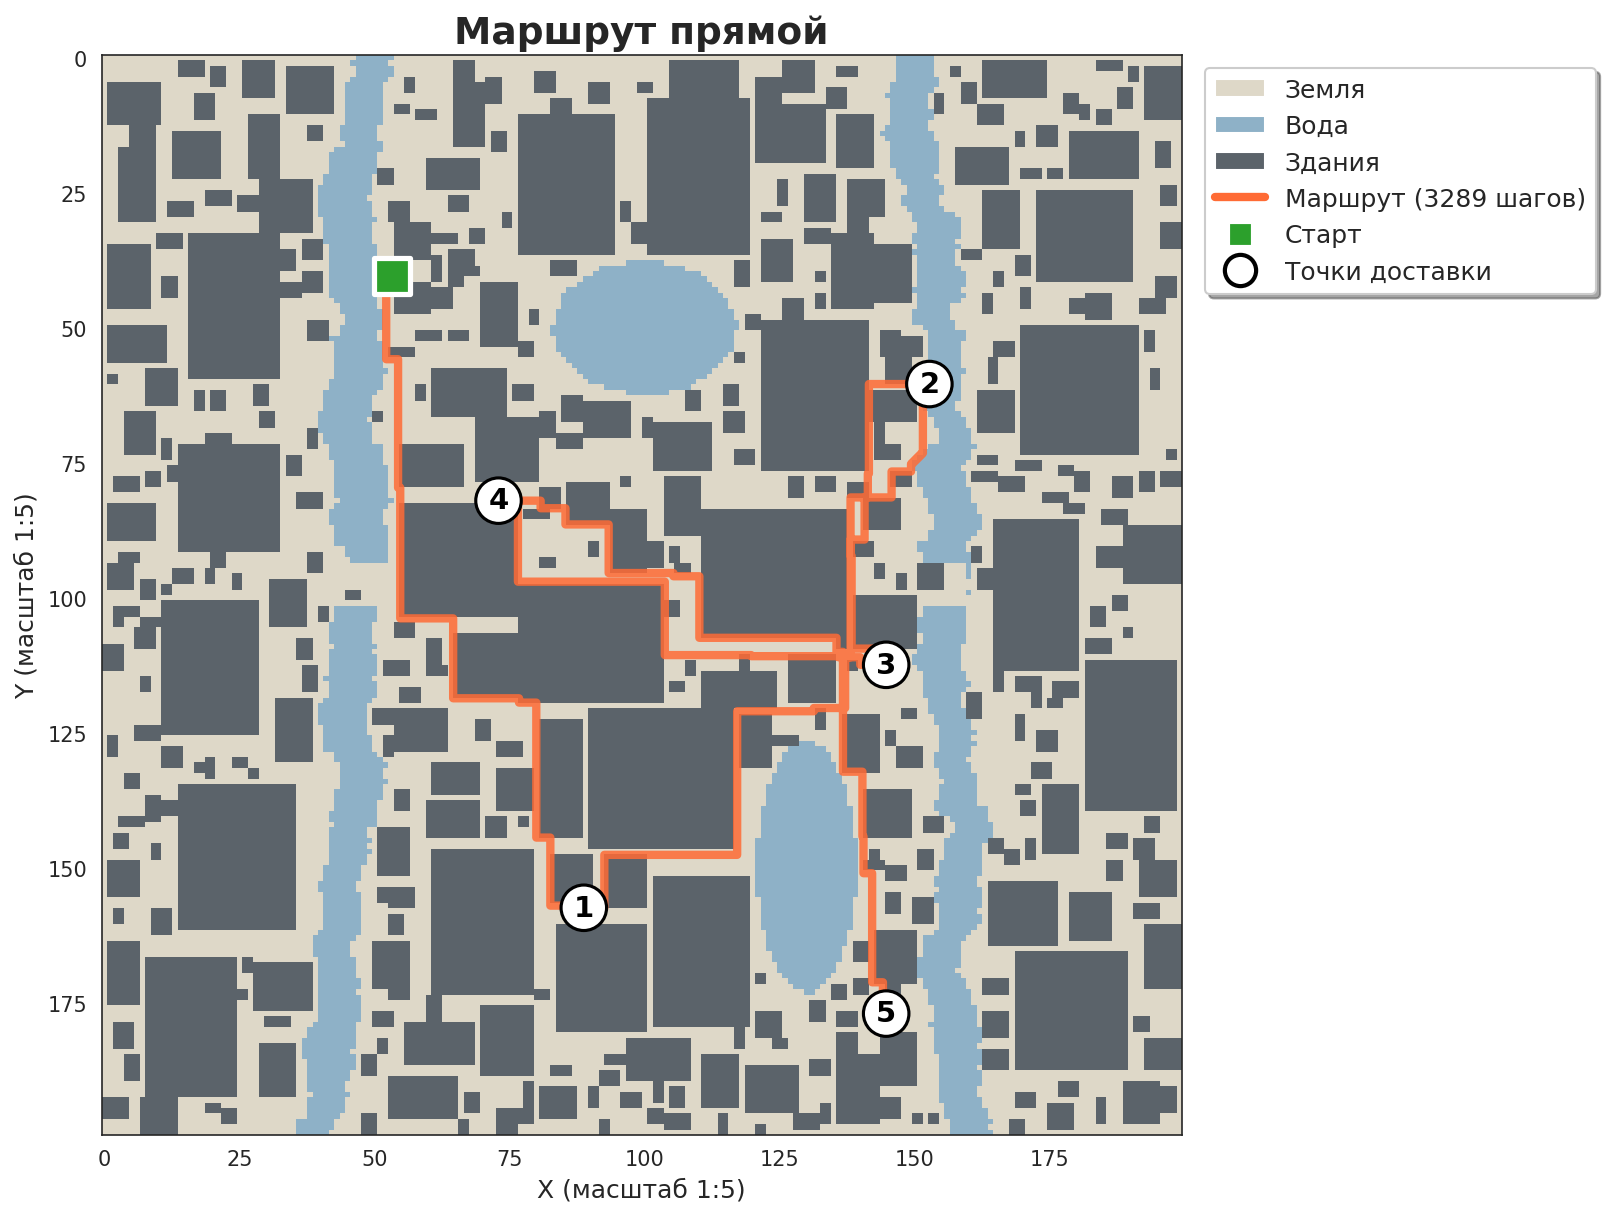

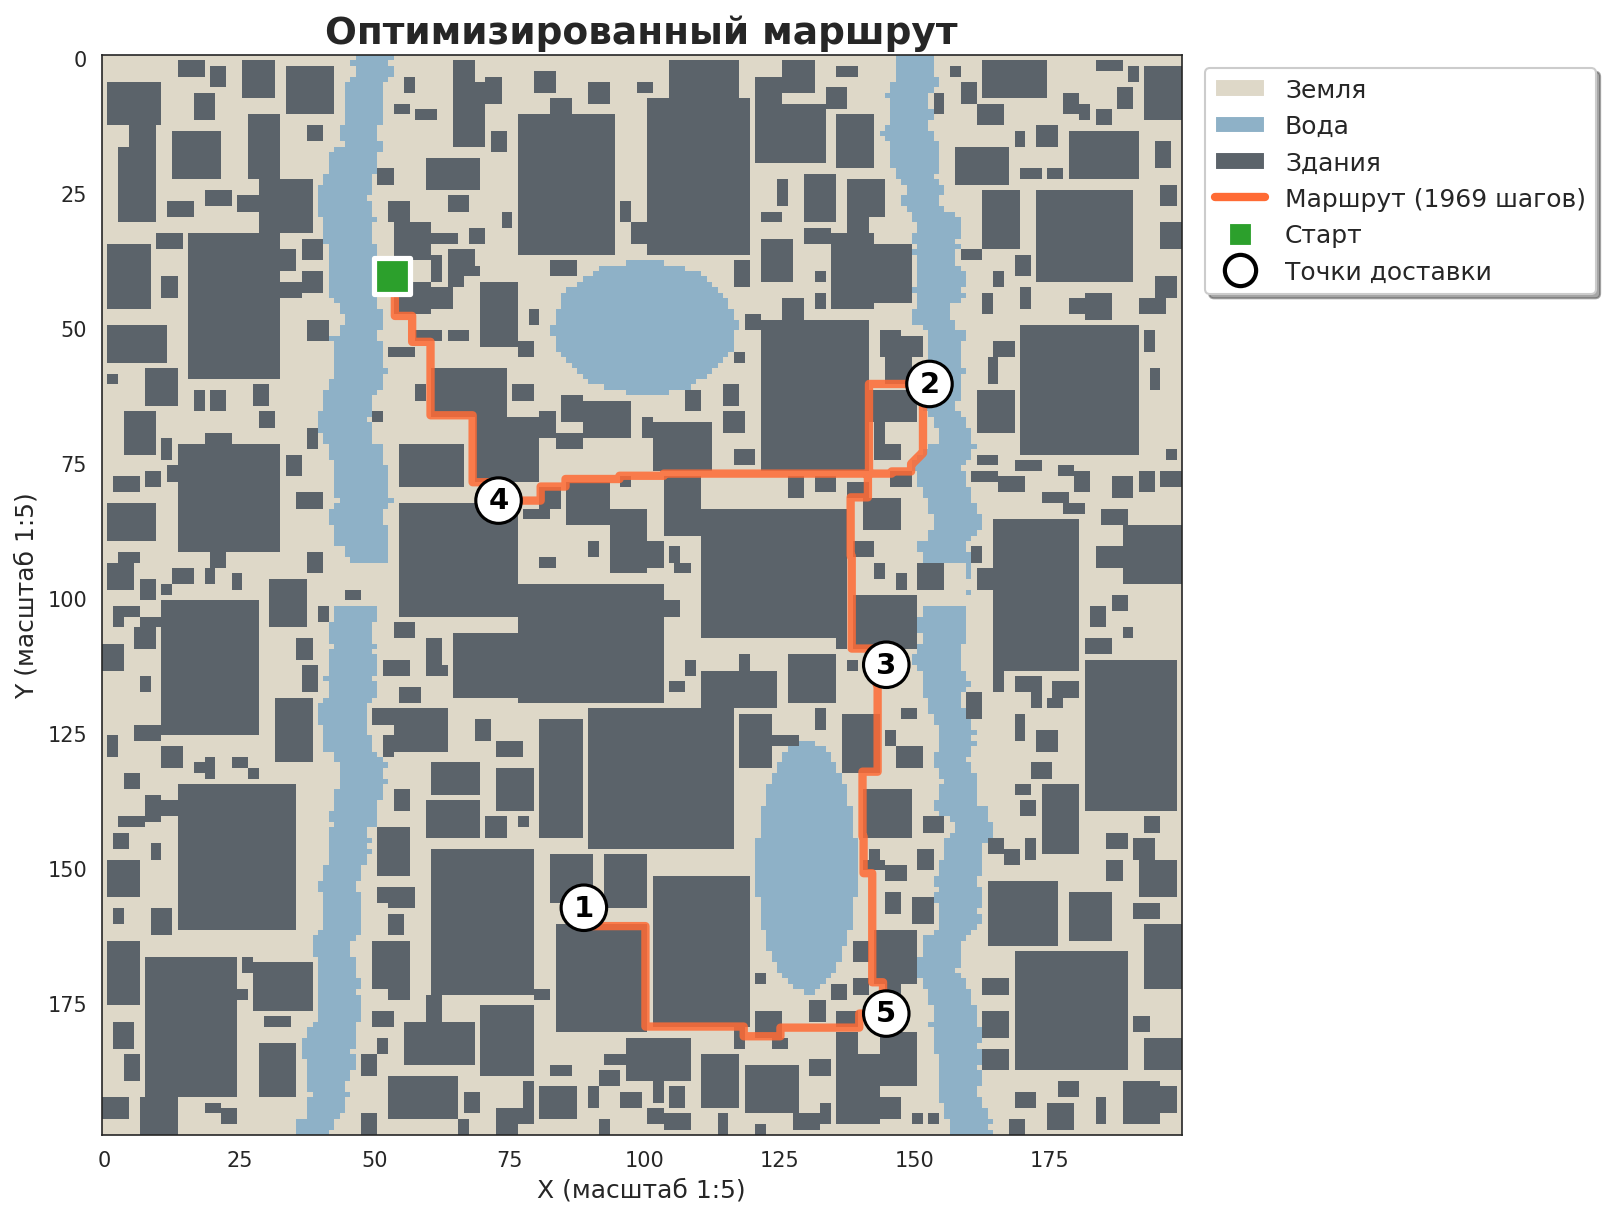


ФИНАЛЬНАЯ СТАТИСТИКА МАРШРУТОВ
Прямой маршрут:           3289 шагов
Оптимизированный:         1969 шагов
Экономия:                 1320 шагов (40.1%)


In [6]:
# Параметры конфигурации и запуск программы
if __name__ == '__main__':
    # Все параметры генерации в одном месте
    CONFIG = {
        'map': {
            'height': 1000,
            'width': 1000
        },
        'rivers': [
            {'start_x': 250, 'start_y': 0, 'width_range': (40, 60), 'target_edge': 'bottom'},
            {'start_x': 750, 'start_y': 0, 'width_range': (35, 55), 'target_edge': 'bottom'}
        ],
        'bridges': {
            'num_bridges': 1,
            'bridge_width': 40
        },
        'lakes': [
            {'center_x': 500, 'center_y': 250, 'radius_x': 110, 'radius_y': 80},
            {'center_x': 650, 'center_y': 750, 'radius_x': 60, 'radius_y': 150}
        ],
        'buildings': {
            'крупных': {'count': 20, 'width_range': (80, 150), 'height_range': (80, 150), 'attempts': 200},
            'средних': {'count': 100, 'width_range': (30, 70), 'height_range': (30, 70), 'attempts': 1000},
            'малых': {'count': 300, 'width_range': (10, 25), 'height_range': (10, 25), 'attempts': 3000}
        }
    }

    # Цветовая схема
    COLORS = {
        'land': '#DED8C8',      # песочно-бежевый
        'water': '#8EB1C7',     # приглушенный синий
        'building': '#5B636A'   # темно-серый
    }

    # 1. Генерация карты
    map_generator = CityMapGenerator(CONFIG)
    city_map = map_generator.get_map()

    # 2. Создание визуализатора
    visualizer = MapVisualizer(city_map, COLORS)

    # 3. Визуализация базовой карты
    visualizer.plot(scale=5)

    # 4. Вывод статистики
    print("\n" + "=" * 70)
    print("СТАТИСТИКА СГЕНЕРИРОВАННОЙ КАРТЫ")
    print("=" * 70)
    H, W = city_map.shape
    total_cells = H * W
    print(f"Размер: {H}×{W}")
    print(f"Земля: {(city_map == 1).sum()} клеток ({(city_map == 1).sum() / total_cells * 100:.1f}%)")
    print(f"Вода: {(city_map == 0).sum()} клеток ({(city_map == 0).sum() / total_cells * 100:.1f}%)")
    print(f"Здания: {(city_map == 2).sum()} клеток ({(city_map == 2).sum() / total_cells * 100:.1f}%)")
    print("=" * 70)

    # 5. Создание навигатора
    nav = Navigator(city_map)

    # 6. Генерация точек доставки
    print("\n" + "=" * 70)
    print("ГЕНЕРАЦИЯ ТОЧЕК ДОСТАВКИ")
    print("=" * 70)
    courier_location = find_valid_point(city_map)
    print(f"Местоположение курьера: {courier_location}")

    delivery_points = []
    for i in range(5):
        point = find_valid_point(city_map)
        if point:
            delivery_points.append(point)
            print(f"Точка доставки {i+1}: {point}")

    # 7. Построение маршрутов
    print("\n" + "=" * 70)
    print("ПОСТРОЕНИЕ МАРШРУТОВ")
    print("=" * 70)
    
    route_direct = nav.route_in_order(courier_location, delivery_points)
    print(f"Прямой маршрут: {len(route_direct)} шагов")

    route_optimized = nav.route_greedy(courier_location, delivery_points)
    print(f"Оптимизированный маршрут: {len(route_optimized)} шагов")

    # 8. Визуализация маршрутов
    visualizer.plot(scale=5, title='Маршрут прямой', 
                    route=route_direct, start=courier_location, deliveries=delivery_points)
    
    visualizer.plot(scale=5, title='Оптимизированный маршрут', 
                    route=route_optimized, start=courier_location, deliveries=delivery_points)

    # 9. Вывод финальной статистики
    if route_direct and route_optimized:
        print("\n" + "=" * 70)
        print("ФИНАЛЬНАЯ СТАТИСТИКА МАРШРУТОВ")
        print("=" * 70)
        steps_d, steps_o = len(route_direct), len(route_optimized)
        saving = steps_d - steps_o
        print(f"Прямой маршрут:         {steps_d:6} шагов")
        print(f"Оптимизированный:       {steps_o:6} шагов")
        print(f"Экономия:               {saving:6} шагов ({saving/steps_d*100:.1f}%)")
        print("=" * 70)

### Выводы

Задача решена. В каждом запуске кода находятся рандомные точки доставки и старта, но в среднем экономия на построенным жадным алгоритмом маршруте, по сравнению с прямым, составляет от 20% до 50% шагов.